# **DSCI-100 Project Report**

In [11]:
### Run this cell to load packages
library(tidyverse)
library(repr)
library(RColorBrewer)

## **Introduction**

#### BACKGROUND

The electronic gaming industry has developed rapidly in recent years, and player participation not only affects game operations, but also provides a rich source of data for academic research. The data used in this project comes from a research group in Computer Science at UBC, led by Frank Wood. They built a Minecraft server to record player behavior data in the virtual world, aiming to explore player behavior patterns and provide a basis for resource management and recruitment strategies.
Due to the resource costs involved in studying server operation, such as software licenses and server capacity, predicting the active time and number of players is crucial to ensure stable server operation. Therefore, this project is a very realistic and challenging data science application scenario. 

#### RESEARCH QUESTIONS

The research team proposed three broad questions, and this project chose the third one: We are interested in demand forecasting, namely, what time windows are most likely to have a large number of simultaneous players. In other words, the question we want to answer is: Can we use the session start times to determine which month is most likely to have a high number of concurrent players on the Minecraft server? 


#### DATA

We were given 2 datasets:
1. **players.csv**: Contains information about individual players who have joined the server(196 players). This includes demographic information, playtime, and whether they subscribed to a newsletter.
2. **sessions.csv**: Records details of each gameplay session for all players, including start and end times in both string and Unix timestamp format.

In [12]:
#run this cell to load in the players and sessions datasets
players  <- read_csv("https://raw.githubusercontent.com/SamuelPastrami/DSCI-PROJECT/refs/heads/main/Data/players.csv")
sessions <- read_csv("https://raw.githubusercontent.com/SamuelPastrami/DSCI-PROJECT/refs/heads/main/Data/sessions.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
### run this cell to view the first 6 rows of the players and sessions datasets
head(players)
head(sessions)

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


#### Summary of Datasets

**1. player.csv Data:**

The dataset contains **7** variables and **196** observations.
- A potential issue is that the majority of played_hours values are 0, which may affect data visualization.
- However, since no variables from this dataset were used, no data wrangling or analysis was performed.

**2. session.csv Data:**

The dataset contains **5** variables and **1,535** observations.
The potential issues in this dataset are: 
- start_time and end_time are not tidy, as they combine date, month, year, and time into a single variable.
- original_start_time and original_end_time are recorded as Unix timestamps (seconds since January 1, 1970, UTC). These may need conversion to categorize data by month.

## **Code Cells**

In [15]:
### run this cell to tidy sessions dataset
convert_date  <- sessions |>
                select(original_start_time) |>                           
                mutate(start_time_seconds = original_start_time/1000) |> #convert from milliseconds to seconds
                mutate(date = as_date(as_datetime(start_time_seconds)))

separate_date <- convert_date |>
                mutate(year  = year(date),
                       month = month(date, label = TRUE),
                       date  = day(date)) |>
                select(year, month, date) 

sessions_tidy <- separate_date |>
                mutate(year  = as.factor(year),
                       month = as.factor(as.character(month)),
                       date  = as.double(date))
head(sessions_tidy)

year,month,date
<fct>,<fct>,<dbl>
2024,Jun,30
2024,Jun,18
2024,Jul,25
2024,Jul,25
2024,May,25
2024,Jun,23


**Summary of changes (Dataset conversion):**

In the process of converting the unix timestamp, we found that our unix timestamp was recorded in milliseconds instead of seconds. 
- The Unix timestamp, originally recorded in milliseconds, was converted into separate year, month, and date columns. 
- The year and month columns were converted to factor variables, while the date column was stored as a double-precision floating point number.

In [10]:
monthly_joins <- sessions_tidy |>
  group_by(month) |>
  summarise(count = n()) 
monthly_joins

month,count
<fct>,<int>
Apr,143
Aug,219
Jul,288
Jun,448
May,344
Sep,93


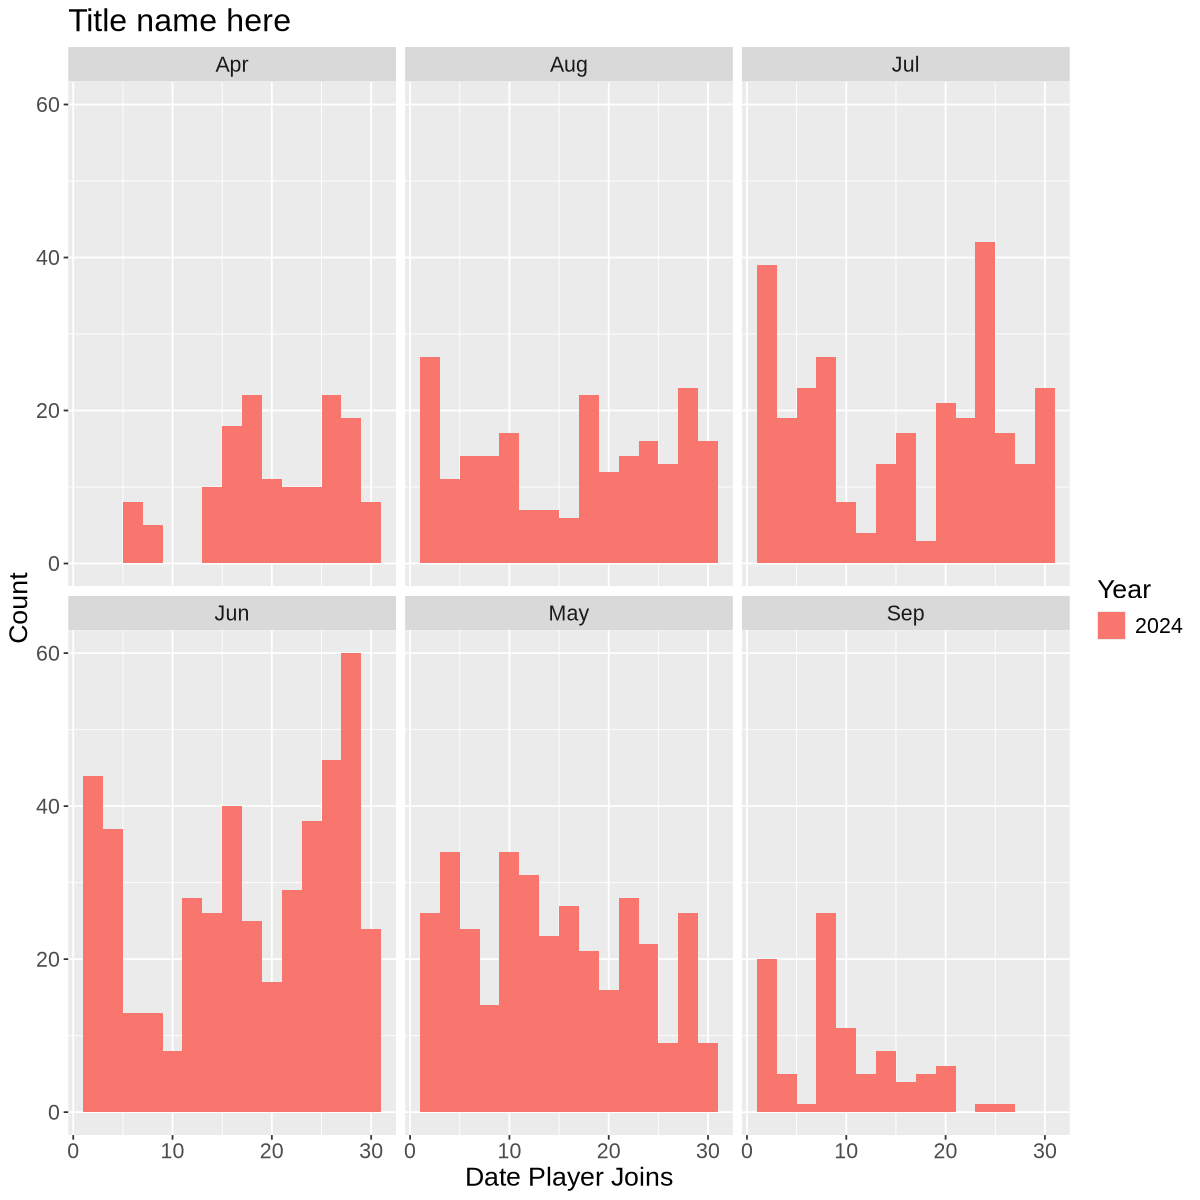

In [6]:
### run this cell to generate a histogram plot of pleyer join dates from seesions dataset
options(repr.plot.width = 10, repr.plot.height = 10)

histogram <- sessions_tidy |>
             ggplot(aes(x = date, fill = year)) + 
             geom_histogram(binwidth = 2) +
             labs(x = "Date Player Joins",
                  y = "Count",
                  fill = "Year") +
             facet_wrap(facets = vars(month)) +
             ggtitle("Title name here") +
             theme(text = element_text(size = 16)) +
             scale_color_brewer(palette = "Set1")
histogram